 Homework #1
===============================================
Iryna Butsky

Problem 1: Querying and data analysis with SDSS
================================

Tasks
-----

1. Use the schema browser to familiarize yourself with the contents of a view named `Star`. Then:
   * Write (and execute) an SQL query to count how many stars have been observed with SDSS (in the current Data Release 12).
   * Write (and execute) an SQL query to count how many observations there are in `u`, `g`, `r`, `i` and `z` bands, and the average observed magnitude in each band. How does the SDSS database record missing (magnitude) data?
   
I ran and executed the SQL queries and found that there are 260562744 observed stars in the current SDSS data release.
Because SDSS records missing data with '-9999', I included a statement that said 'where s.dered\_(BAND) \> 0' in my query jobs. 


|Band|# Observations| Ave. Magnitude |
|--|-------------------------------|
| u | 259257394 | 22.0432011610265 |
| g | 259674707 | 21.2385618276304 |
| r | 259944363 | 20.4086165770081 |
| i | 260106524 | 19.8455967341626 |
| z | 260240892 | 19.4805404870099 |


2.Write an SQL query to select the positions ($\alpha$, also known as `ra`, and $\delta$, also know as `dec`) and the extinction-corrected (a.k.a. *dereddened*) `g` and `r`-band magnitudes of all stars bounded by $225 < \alpha < 235$ and $-2.5 < \delta < 4$. Your query should store the outputs into a temporary table in MyDB. Download it as a FITS file. Use the `astropy.tables` module to load the table data into Python, then store it into a local sqlite database (using `Pandas` to_sql() functions).

In [2]:
import pandas as pd
import numpy as np
import sqlite3
%matplotlib inline
import matplotlib.pyplot as plt
from astropy.table import Table

In [30]:
field = Table.read('/astro/users/ibutsky/hw1_ibutsky.fit')

In [31]:
field[:10]

objid,ra,dec,Ar,g,r,gErr,rErr,flags
int64,float64,float64,float32,float32,float32,float32,float32,int64
1237648702984683694,225.069991367,-1.14170540202,0.174639,23.6512,22.3767,0.303685,0.166218,105622137733392
1237648702984683882,225.07080966,-1.2293737258,0.178989,18.44,17.8425,0.0079404,0.00656557,158398662443520
1237648702984684106,225.069106255,-1.15498119453,0.175259,20.2551,20.2981,0.0235409,0.0324961,35253360001584
1237648702984684109,225.070651399,-1.22152050113,0.178522,24.2291,22.2306,0.447715,0.15429,175990848488280
1237648702984684111,225.069937885,-1.05681711259,0.169986,25.4961,25.2599,0.423332,0.530403,439804919677184
1237648702984684112,225.071020804,-1.12593105178,0.173862,26.0172,23.8832,0.409508,0.663913,299067431321856
1237648702984684574,225.068896523,-1.14491286616,0.174832,22.0138,20.6225,0.0815648,0.0383072,68987912448
1237648702984685062,225.070545121,-1.16089137675,0.175441,24.2183,23.1083,0.45243,0.321784,281543964623104
1237648702984685064,225.070610142,-1.08575952842,0.171716,23.3655,20.8496,1.77782,0.278941,105622104179472


In [40]:
pf = field.to_pandas()

In [85]:
con = sqlite3.connect('butsky_hw1.db')
pf.to_sql('butsky_hw1_table', con, if_exists = 'replace')

3.In an IPython notebook, make an $ra$ vs $dec$ scatter plot of the data. Note that the right ascension by convention increases from right to left; make sure your plot reflects that. What do you see near $\alpha \sim 229$ and $\delta \sim 0$? Do know what is this object?

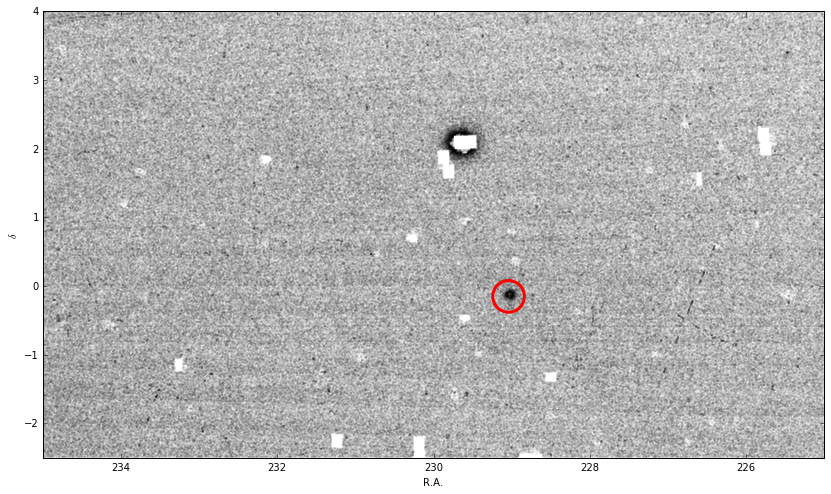

In [39]:
fig, ax = plt.subplots(figsize=(14,8))
ax.scatter(field['ra'], field['dec'], marker='.', s = 0.005)
# bringing attention to the feature mentioned above by circling it
ax.scatter(229.04, -.15, s=1000, linewidth = 3, facecolors='none', edgecolors='r')
ax.set_xlim(235, 225)
ax.set_ylim(-2.5,4)
ax.set_xlabel("R.A.")
ax.set_ylabel("$\delta$")

I think that the feature at ~ $\alpha \simeq 229$ and $\delta \simeq 0$ is a globular cluster. (In part because what we're looking at are stars, and that feautre seems like a dense clump of stars to me. In part because the link in the prompt confirms that suspicion ;) 

4.Select a subset of the data in a region (a rectangle is fine!) tightly bounding the observed object. Select data in another, equally sized region, nearby but *away* from the object. Do the selection in two ways: with an SQL query of your local sqlite database, and using the indexing operators in Python (the square brackets '[]'). Show that the two give identical results (it's sufficient to show they return the same number of rows for the same constraints).

In [88]:
# Method 1: Loading in from the created sql table
# glob_from_sql is the region around the globular cluster
# rand_from_sql is the random region of the same size
glob_from_sql = pd.read_sql("""
    SELECT
        butsky_hw1_table.ra,  butsky_hw1_table.dec, 
         butsky_hw1_table.g,  butsky_hw1_table.r
    FROM
        butsky_hw1_table 
    WHERE 
        ra > 228.95 and ra < 229.1
        and dec > -0.25 and dec < 0.0
""", con)

rand_from_sql = pd.read_sql("""
    SELECT
        butsky_hw1_table.ra,  butsky_hw1_table.dec, 
         butsky_hw1_table.g,  butsky_hw1_table.r
    FROM
        butsky_hw1_table 
    WHERE 
        ra > 229.55 and ra < 229.7
        and dec > -0.25 and dec < 0.0
""", con)

In [89]:
# Printing out the number of stars in each region
print len(glob_from_sql), len(rand_from_sql)

2093 657


In [107]:
# Method 2: Python indexing operators
# setting up masks of the desired region (glob_mask) and a random region
# of the same size, but shifted over in R.A. (rand_mask)
glob_mask = (228.95 < field['ra']) & (field['ra'] < 229.1) \
    &(-0.25 < field['dec']) & (field['dec'] < 0.0)
rand_mask = (229.55 < field['ra']) & (field['ra'] < 229.7) \
    &(-0.25 < field['dec']) & (field['dec'] < 0.0)

# the length of the masked fields should give the number of stars in that region
print len(field['ra'][glob_mask]), len(field['ra'][rand_mask])

2093 657


Both methods found that there are 2093 stars in the region surrounding the globular cluster and 657 stars in a randomly selected nearby region of the same size. 

5.Make two side-by-side scatter plots of the (dereddened) $g-r$ color vs $g$-band magnitude. Note that the magnitude axis, by convention, always increases from top to bottom; make sure your plot reflects that. Compare the two and describe what you see.

In [103]:
def add_cmd(ax, data, title):
    data = data[(data['g'] > 0) & (data['r'] > 0)]

    g = data['g']
    r = data['r']
    gr = g - r

    ax.scatter(gr, r, marker='.', s = 0.8)
    ax.set_xlim(-1, 2.5)
    ax.set_ylim(26, 13)

    ax.set_xlabel("g - r")
    ax.set_ylabel("r")
    ax.set_title(title)



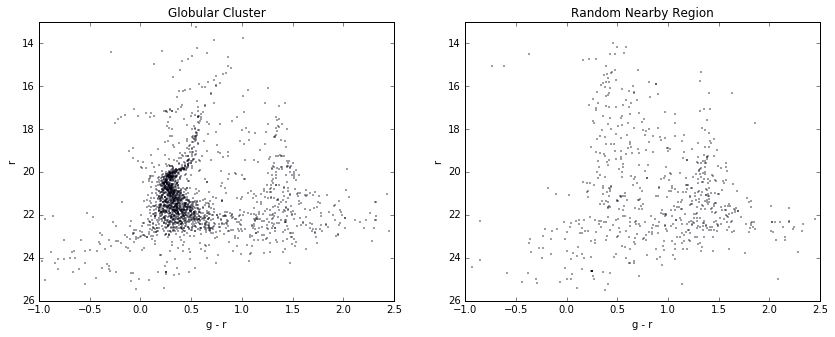

In [108]:
fig, ax = plt.subplots(ncols=2,nrows=1, figsize=(14,5))
add_cmd(ax[0], field[glob_mask], 'Globular Cluster')
add_cmd(ax[1], field[rand_mask], 'Random Nearby Region')


The plot on the left (of the globular cluster) has a strong HR feature  with a 'knee' at g-r ~ 0.4 and r ~ 20. Both plots have very similar features around g-r ~ 1.5. 

6.Identify a region in $g-r$ vs $g$ plot where the difference between the two plots appears greatest. From your original sample, select stars only present in that *color-magnitude* box, and plot them in $ra$ vs $dec$ scatter plot. Do you notice anything interesting?

In [131]:
gr = field['g']-field['r']
cm_box = (228.95 < field['ra']) & (field['ra'] < 229.1) \
    &(-0.25 < field['dec']) & (field['dec'] < 0.0)\
    &(0 < gr) * (gr < 0.9)
not_cm_box = (228.95 < field['ra']) & (field['ra'] < 229.1) \
    &(-0.25 < field['dec']) & (field['dec'] < 0.0)\
    &((0.9 < gr) | (gr < 0))

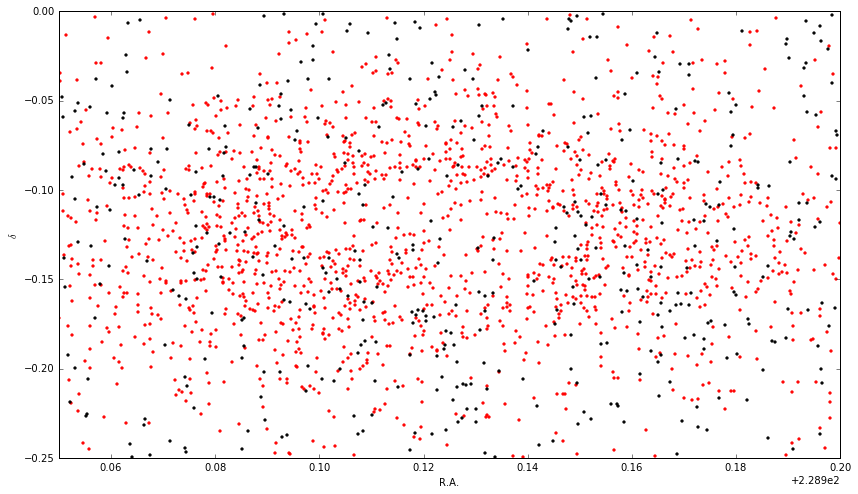

In [134]:
fig, ax = plt.subplots(figsize=(14,8))
ax.scatter(field['ra'][cm_box], field['dec'][cm_box],\
          color = 'red', marker='.')
ax.scatter(field['ra'][not_cm_box], field['dec'][not_cm_box], \
        color = 'black', marker='.')
ax.set_xlim(228.95, 229.1)
ax.set_ylim(-.25,0)
ax.set_xlabel("R.A.")
ax.set_ylabel("$\delta$")

In the plot above, I used red markers to show the R.A. / dec of the stars in the c-r feature and black for the stars in the region that aren't in that feature. It looks like the stars in the HR diagram region of the C-R diagram are all in the cluster, whereas the stars that aren't are the background (or foreground) stars. 

7.Extra credit: how would you make the determination of the $g-r$ vs $g$ selection box more quantitative?

It would be really cool to adaptively divide the g-r, r space such that there's no more than star per 'box'. We can then merge the boxes back together (up to a desired resolution) to create a density plot. The blank boxes will help give uncertainties to the density values. From there we can subtract the two fields' density plots in g-r, r space. If they are similar, we expect the difference of the densities to be zero, within a given tolerance. If there is a significant difference we expect to see relatively high (or low) values, and we can find the boundary-of-interest edge where the standard deviation is sufficiently high. 

Problem 2: Importing data into the Large Survey Database
========================================================
* Install the Large Survey Database (see Lecture #3 for instructions)
* Read about the [data contained in sweep files](http://dr12.sdss3.org/datamodel/files/PHOTO_SWEEP/RERUN/calibObj.html) for stars. Write a corresponding YAML LSD schema file. Make sure it consists of (at least) four tablets: basic quantities, photometry, image, resolve and calibration quantities, and the 2MASS match information. Create an LSD table with that schema.
* Download all files belonging to run 94, from http://data.sdss3.org/sas/dr12/boss/sweeps/dr9/301/. Use `lsd-import` to import these files.
* Use `lsd-footprint` to compute the footprint of the run, and plot the result.


In [142]:
! conda config --add channels http://www.astro.washington.edu/users/mjuric/conda


Skipping channels: http://www.astro.washington.edu/users/mjuric/conda, item already exists


In [143]:
! conda install lsd --yes


Fetching package metadata: .....Error: HTTPError: 403 Client Error: Forbidden for url: http://www.astro.washington.edu/users/ibutsky/conda/linux-64/repodata.json.bz2: http://www.astro.washington.edu/users/ibutsky/conda/linux-64/



In [145]:
from lsd import DB # database class
from lsd.bounds import beam, rectangle
import os

In [150]:
os.environ['NWORKERS'] = '8' # note: value has to be a string (number of cores we allow it to run on)
os.environ['LSD_CACHEDIR'] = os.environ['HOME'] + '/tempdir' 
os.environ['LSD_TEMPDIR'] = os.environ['HOME'] + '/tempdir'
os.environ['LSD_DB'] = os.environ['HOME'] + '/lsddb'


(Copy-paste of my YAML file)

filters: {complevel: 5, complib: blosc}
schema:
  common:
    primary_key: SDSS_ID
    spatial_keys: [RA, DEC]
    columns:
    - [SDSS_ID, u8]
    - [RUN, i2]
    - [RERUN, a3]
    - [CAMCOL, u8]
    - [FIELD, i2]
    - [ID, i2]
    - [OBJC_TYPE, i4]
    - [OBJC_FLAGS, i4]
    - [OBJC_FLAGS2, i4]
    - [OBJC_ROWC, f4]
    - [ROWVDEG, f4]
    - [ROWVDEGERR, f4]
    - [COLVDEG, f4]
    - [COLVDEGERR, f4]
    - [ROWC, 5f4]
    - [COLC, 5f4]
    - [M_RR_CC, 5f4]
    - [M_RR_CC_PSF, 5f4]
    - [FLAGS, 5i4]
    - [FLAGS2, 5i4]
    - [ZHEDFLAG, i2]
    - [RA, f8]
    - [DEC, f8]
    - [PSP_STATUS, i4]
  photometric:
    columns:
    - [SKYFLUX, 5f4]
    - [PSFFLUX, 5f4]
    - [PSFFLUX_IVAR, 5f4]
    - [MODELFLUX, 5f4]
    - [MODELFLUX_IVAR, 5f4]
    - [EXTINCTION, 5f4]
    - [APERFLUX6, 5f4]
    - [FIBERFLUX, 5f4]
    - [FIBERFLUX_IVAR, 5f4]
    - [FIBER2FLUX, 5f4]
    - [FIBER2FLUX_IVAR, 5f4]
  image:
    columns:
    - [PSF_FWHM, 5f4]
    - [CALIB_STATUS, 5i4]
    - [RESOLVE_STATUS, i4]
    - [THING_ID, i4]
    - [IFIELD, i4]
    - [BALKAN_ID, i4]
    - [NDETECT, i4]
    - [NMGYPERCOUNT, 5f4]
    - [PM_MATCH, i4]
    - [PMRA, f4]
    - [PMDEC, f4]
    - [PMRAERR, f4]
    - [PMDECERR, f4]
    - [PM_SIGRA, f4]
    - [PM_SIGDEC, f4]
    - [PM_NFIT, i4]
    - [PM_DIST22, f4]
    - [CMODELFLUX_CLEAN, 5f4]
    - [CMODELFLUX_CLEAN_IVAR, 5f4]
    - [CMODELFLUX_CLEAN_VAR, 5f4]
    - [CMODELFLUX_CLEAN_CHI2, 5f4]
    - [CMODEL_CLEAN_NUSE, 5i2]
    - [CMODEL_CLEAN_MJD_MAXDIFF, 5i4]
    - [CMODEL_CLEAN_MJD_VAR, 5f4]
    - [MODELFLUX_CLEAN_CHI2, 5f4]
    - [MODEL_CLEAN_NUSE, 5i2]
    - [MODEL_CLEAN_MJD_MAXDIFF, 5i4]
    - [MODEL_CLEAN_MJD_VAR, 5f4]
    - [PSFFLUX_CLEAN, 5f4]
    - [PSFFLUX_CLEAN_IVAR, 5f4]
    - [PSFFLUX_CLEAN_VAR, 5f4]
    - [PSFFLUX_CLEAN_CHI2, 5f4]
    - [PSF_CLEAN_NUSE, 5i2]
    - [PSF_CLEAN_MJD_MAXDIFF, 5i4]
    - [PSF_CLEAN_MJD_VAR, 5f4]
  2mass_match:
    columns:
    - [TMASS_J, f4]
    - [TMASS_J_IVAR, f4]
    - [TMASS_H, f4]
    - [TMASS_H_IVAR, f4]
    - [TMASS_K, f4]
    - [TMASS_K_IVAR, f4]
    - [TMASS_PH_QUAL, a3]
    - [TMASS_RD_FLG, i2]
    - [TMASS_BL_FLG, i2]
    - [TMASS_CC_FLG, a3]
    - [TMASS_GAL_CONTAM, u1]
    - [TMASS_MP_FLG, u1]
    - [TMASS_HEMIS, a1]
    - [TMASS_JDATE, f8]


In [183]:
! lsd-admin create table --schema caliobj.yaml caliobj --drop-existing

Table 'caliobj' dropped.

-------- committing 20160301205522.857800 [caliobj] ---------
[caliobj] Updating tablet catalog: [256 el.]::::::::::::::::::::>  0.24 sec
[caliobj] Updating neighbors: Already up to date.
[caliobj] Updating tablet catalog: [256 el.]::::::::::::::::::::>  0.24 sec
[caliobj] Updating stats: [0 el.]>  0.00 sec
[caliobj] Marking tablets read-only...
----------- success 20160301205522.857800 [caliobj] ---------

Table 'caliobj' created.


In [184]:
! lsd-import fits caliobj calibObj-000094-1-star.fits.gz  calibObj-000094-5-star.fits.gz \
    calibObj-000094-2-star.fits.gz  calibObj-000094-6-star.fits.gz \
    calibObj-000094-3-star.fits.gz  calibObj-000094-4-star.fits.gz  


Importing from 6 pieces:
  ===> Imported calibObj-000094-4-star.fits.gz                                         [1/6, 16.67%] + 130027/130027     130027 (0/2 min.)
  ===> Imported calibObj-000094-1-star.fits.gz                                         [2/6, 33.33%] + 133515/133515     263542 (0/1 min.)
  ===> Imported calibObj-000094-6-star.fits.gz                                         [3/6, 50.00%] + 138113/138113     401655 (0/1 min.)
  ===> Imported calibObj-000094-2-star.fits.gz                                         [4/6, 66.67%] + 155355/155355     557010 (0/0 min.)
  ===> Imported calibObj-000094-3-star.fits.gz                                         [5/6, 83.33%] + 124832/124832     681842 (0/0 min.)
  ===> Imported calibObj-000094-5-star.fits.gz                                         [6/6, 100.00%] + 136292/136292     818134 (0/0 min.)
done

-------- committing 20160301205528.966909 [caliobj] ---------
[caliobj] Updating tablet catalog: [256 el.]::::::::::::::::::::>  0.37 

In [185]:
! lsd-footprint caliobj foot.fits


 [48 el.]::::::::::::::::::::>  1.33 sec
Objects: 818134.0


In [187]:
! ls

basic.yaml			caliobj.yaml
basic.yaml~			caliobj.yaml~
butsky_hw1.db			foot.fits
calibObj-000094-1-star.fits.gz	hw1_1.ipynb
calibObj-000094-2-star.fits.gz	hw1_2.ipynb
calibObj-000094-3-star.fits.gz	image.yaml
calibObj-000094-4-star.fits.gz	old_caliobj.yaml
calibObj-000094-5-star.fits.gz	photometric.yaml
calibObj-000094-6-star.fits.gz


In [36]:
from matplotlib.colors import LogNorm
from astropy.io import fits
foot = fits.getdata('foot.fits')


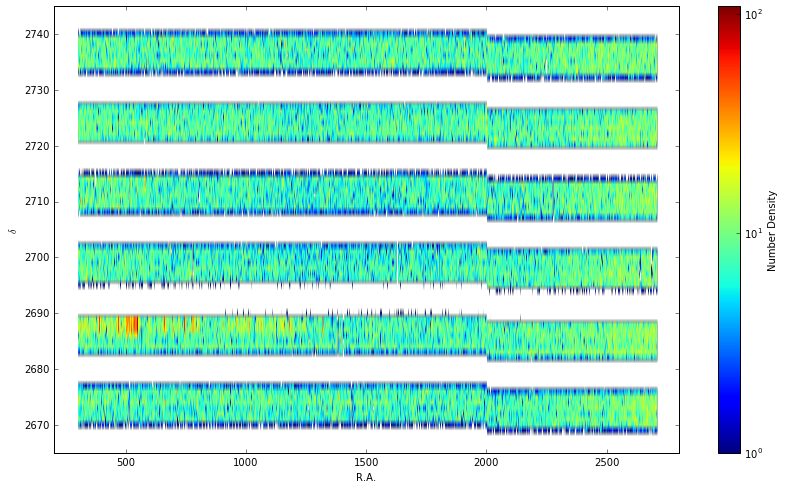

In [43]:
fig, ax = plt.subplots(figsize=(14,8))
cax = ax.imshow(np.roll(foot,2000), norm = LogNorm(), aspect='auto')
fig.colorbar(cax, label = 'Number Density')
ax.set_ylim(2665, 2745)
ax.set_xlim(200, 2800)
ax.set_xlabel('R.A.')
ax.set_ylabel('$\delta$')
plt.show()


(I'm not sure how to deal with the units above. The declination range is ~ 70 degrees, but I'm not sure what the absolute units are. I also shifted the empty space in the R.A. using np.roll